In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Jun 27 23:51:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install livelossplot

In [ ]:
import os 
import cv2
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten, Input, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.regularizers import l2
from keras.models import Model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import RMSprop, SGD
from keras.callbacks import History, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.constraints import unit_norm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from livelossplot.inputs.keras import PlotLossesCallback
%matplotlib inline

# **20 Breeds**

## **Baseline model**

### Data Preparation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#set the training path
training_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/training_data'
#set the validation path
validation_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/validation_data'
#set the test path
test_path='/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data'

In [ ]:
def create_dataset(folder_path,breed_classes):
  
  image_arrays=[]
  image_classes=[]

  for breed in os.listdir(folder_path):
    if breed in breed_classes:
      breed_path=os.path.join(folder_path,breed)
      for img in os.listdir(breed_path):
        
        image=cv2.imread(os.path.join(breed_path,img),cv2.IMREAD_UNCHANGED)
        image = image.astype('float64')
        image /= 255

        image_arrays.append(image)
        image_classes.append(breed)


  return image_arrays , image_classes



In [ ]:
breeds=['basset', 'borzoi', 'Walker_hound', 'bluetick', 'beagle', 'black and tan_coonhound', 'English_foxhound', 'Irish_wolfhound', 'redbone', 'bloodhound', 'Italian_greyhound',
 'whippet', 'Scottish_deerhound', 'Weimaraner', 'Bedlington_terrier', 'American_Staffordshire_terrier', 'Saluki', 'Staffordshire_bullterrier', 'Norwegian_elkhound', 'Ibizan_hound',]

In [ ]:
img_data, class_names=create_dataset(training_path, breeds)

In [ ]:
img_data_val, class_names_val=create_dataset(validation_path, breeds)

In [ ]:
img_data_test, class_names_test=create_dataset(test_path, breeds)

Next, we prepare the labels as a list of label encoded inputs from a **breed list** that we chose 

In [ ]:
target_dict={k: v for v, k in enumerate(np.unique(class_names))}
target_val=  [target_dict[class_names[i]] for i in range(len(class_names))]

In [ ]:
target_dict_val={k: v for v, k in enumerate(np.unique(class_names_val))}
target_val_val=  [target_dict_val[class_names_val[i]] for i in range(len(class_names_val))]

In [ ]:
target_dict_test={k: v for v, k in enumerate(np.unique(class_names_test))}
target_val_test=  [target_dict_test[class_names_test[i]] for i in range(len(class_names_test))]

### Build model

In [ ]:
def create_cnn_model(activation_fn='relu', kernel_s=(3,3), padding='same', drop_rate=0.25,optimizer='adam'):

  #initialize the Sequential model
  model=Sequential()
  #First Conv Layer
  model.add(Conv2D(32, kernel_size=kernel_s, padding=padding, activation='relu',input_shape=(224,224,3)))
  
  #adding the pooling method
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())

  #Second Conv Layer
  model.add(Conv2D(64, kernel_size=kernel_s, padding=padding, activation=activation_fn))
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())

  #third Conv Layer
  model.add(Conv2D(128, kernel_size=kernel_s, padding=padding, activation=activation_fn))
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())

  #fourth Conv Layer with a dropout layer to simplify the model
  model.add(Conv2D(128, kernel_size=kernel_s, padding=padding, activation=activation_fn))
  #model.add(get_pool(poolling))
  model.add(MaxPooling2D())
  model.add(Dropout(drop_rate))

  #Combine the CNN network with the ANN model
  model.add(Flatten())
  model.add(Dense(512,activation=activation_fn))
  model.add(Dropout(drop_rate))
  model.add(Dense(20,activation='softmax'))

  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


  
  return model


We are running the baseline model with 20 breeds to compare it then with the best parameter model

In [ ]:
base_model=create_cnn_model()

In [ ]:
plot_20breeds=PlotLossesCallback()

In [ ]:
base_model=KerasClassifier(build_fn=create_cnn_model, epochs=1000, batch_size=20)

In [ ]:
history_base=base_model.fit(x=np.array(img_data, np.float64),  y=tf.keras.utils.to_categorical(np.array(target_val, dtype=np.float64)),steps_per_epoch=2314//20, epochs=1000, verbose=1,  
                          validation_data=(np.array(img_data_val, dtype=np.float64),tf.keras.utils.to_categorical(np.array(target_val_val, dtype=np.float64))), validation_steps=712 // 20, validation_batch_size=20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/baseline_model_20_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)])

Epoch 1/1000
115/115 [==============================] - 34s 32ms/step - loss: 3.1251 - accuracy: 0.0503 - val_loss: 2.9923 - val_accuracy: 0.0657

Epoch 00001: val_accuracy improved from -inf to 0.06571, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/baseline_model_20_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/baseline_model_20_breeds/assets
Epoch 2/1000
115/115 [==============================] - 3s 24ms/step - loss: 2.9914 - accuracy: 0.0625 - val_loss: 2.9906 - val_accuracy: 0.0657

Epoch 00002: val_accuracy did not improve from 0.06571
Epoch 3/1000
115/115 [==============================] - 3s 25ms/step - loss: 2.9914 - accuracy: 0.0574 - val_loss: 2.9887 - val_accuracy: 0.0657

Epoch 00003: val_accuracy did not improve from 0.06571
Epoch 4/1000
115/115 [==============================] - 3s 25ms/step - loss: 2.9900 - accuracy: 0.0741 - val_loss: 2.9898 - val_accuracy: 0.0657

Epoch 00004: v

No handles with labels found to put in legend.


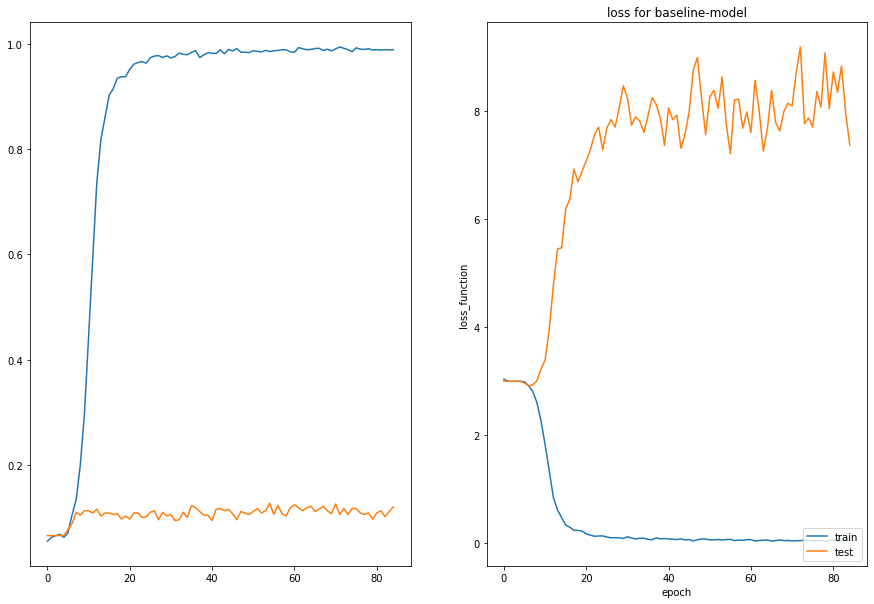

In [ ]:
f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(history_base.history['accuracy'],label='train')
ax1.plot(history_base.history['val_accuracy'],label='test')
plt.title('accuracy for baseline-model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

ax2.plot(history_base.history['loss'],label='train')
ax2.plot(history_base.history['val_loss'],label='test')
plt.title('loss for baseline-model')
plt.ylabel('loss_function')
plt.xlabel('epoch')
plt.legend(loc='lower right')

plt.show()

### Evaluate the model

In [ ]:
base_model.score(x=np.array(img_data_test, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val_test, dtype=np.float64)))

27/27 [==============================] - 1s 10ms/step - loss: 8.2281 - accuracy: 0.0749


0.0749063640832901

As it was expected, we have a very low accuracy value with the baseline model

Moving on to test the 20 breeds with our best hyper-parameters we did get from the 5 breeds model

### best model parameters


In [ ]:
best_params={'padding': 'valid', 'optimizer': 'Adagrad', 'kernel_s': (4, 4), 'drop_rate': 0.3, 'activation_fn': 'tanh'}

In [ ]:
best_model=KerasClassifier(build_fn=lambda: create_cnn_model(**best_params), epochs=1000, batch_size=20 )

In [ ]:
best_model.get_params()

{'batch_size': 20,
 'build_fn': <keras.engine.sequential.Sequential at 0x7f232dea9d90>,
 'epochs': 1000}

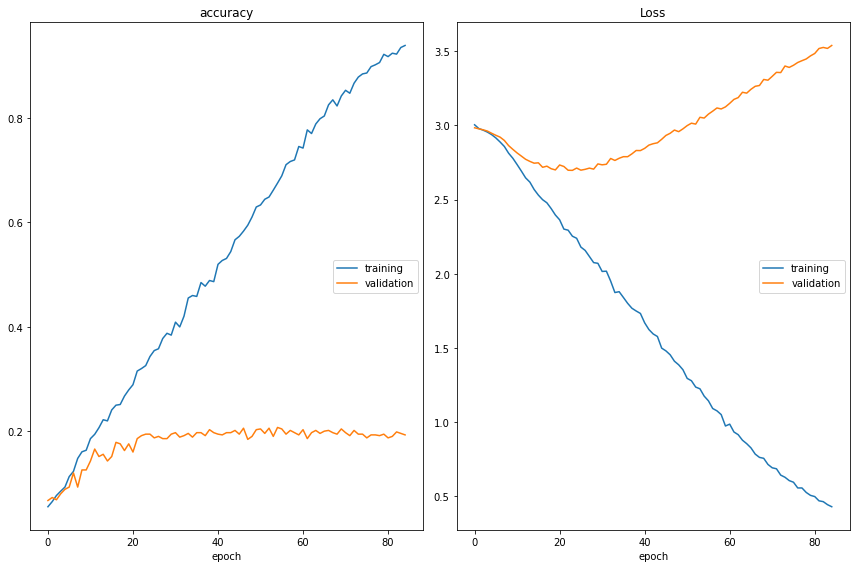

accuracy
	training         	 (min:    0.055, max:    0.939, cur:    0.939)
	validation       	 (min:    0.067, max:    0.207, cur:    0.193)
Loss
	training         	 (min:    0.430, max:    3.004, cur:    0.430)
	validation       	 (min:    2.697, max:    3.539, cur:    3.539)
Epoch 00085: early stopping


In [ ]:
history_best=best_model.fit(x=np.array(img_data, np.float64),  y=tf.keras.utils.to_categorical(np.array(target_val, dtype=np.float64)),steps_per_epoch=2314//20, epochs=1000, verbose=1,  
                          validation_data=(np.array(img_data_val, dtype=np.float64),tf.keras.utils.to_categorical(np.array(target_val_val, dtype=np.float64))), validation_steps=712 // 20, validation_batch_size=20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/baseline_model_20_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1), plot_20breeds])

In [ ]:
best_model.score(x=np.array(img_data_test, np.float64), y=tf.keras.utils.to_categorical(np.array(target_val_test, dtype=np.float64)))

27/27 [==============================] - 1s 12ms/step - loss: 3.1832 - accuracy: 0.1648


0.16479401290416718

We have an improvement of our model performance, as we go from 7% p to 16% 

Lets check next the best augmentation technique to use with the 20 breeds model

PS: the best augmentation technique we get from the 5 breeds model is the **rotation 90°**

In [ ]:
model=create_cnn_model(**best_params)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 221, 32)      1568      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       131200    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 128)       2

### Model : rescaled data augmeuntation

### rescaled data Augmentation

In [ ]:
breeds=['basset', 'borzoi', 'Walker_hound', 'bluetick', 'beagle', 'black and tan_coonhound', 'English_foxhound', 'Irish_wolfhound', 'redbone', 'bloodhound', 'Italian_greyhound',
 'whippet', 'Scottish_deerhound', 'Weimaraner', 'Bedlington_terrier', 'American_Staffordshire_terrier', 'Saluki', 'Staffordshire_bullterrier', 'Norwegian_elkhound', 'Ibizan_hound',]

In [ ]:
train_gen=ImageDataGenerator(rescale=1/255)
train_features=train_gen.flow_from_directory(training_path, classes=breeds, batch_size=20, target_size=(224,224))

Found 2314 images belonging to 20 classes.


### Validation & test data-generators

In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 712 images belonging to 20 classes.


In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20, shuffle=False)

Found 534 images belonging to 20 classes.


In [ ]:
history=model.fit(train_features,steps_per_epoch=2314//20, epochs=1000, verbose=1, 
                          validation_data=aug_validation, validation_steps=aug_validation.n// 20, callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/' + 'rescaled_20_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)])

Epoch 1/1000
115/115 [==============================] - 817s 7s/step - loss: 2.9987 - accuracy: 0.0606 - val_loss: 2.9827 - val_accuracy: 0.0629

Epoch 00001: val_accuracy improved from -inf to 0.06286, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/rescaled_20_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/rescaled_20_breeds/assets
Epoch 2/1000
115/115 [==============================] - 10s 88ms/step - loss: 2.9796 - accuracy: 0.0680 - val_loss: 2.9757 - val_accuracy: 0.0614

Epoch 00002: val_accuracy did not improve from 0.06286
Epoch 3/1000
115/115 [==============================] - 10s 86ms/step - loss: 2.9698 - accuracy: 0.0741 - val_loss: 2.9686 - val_accuracy: 0.0686

Epoch 00003: val_accuracy improved from 0.06286 to 0.06857, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/rescaled_20_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_

### Model rotated: rotated data augmeuntation

### Rotated data augmentation: 90 degrees

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=breeds,
                              class_mode='categorical', batch_size=20)

Found 2314 images belonging to 20 classes.


In [ ]:
plot_20breeds=PlotLossesCallback()

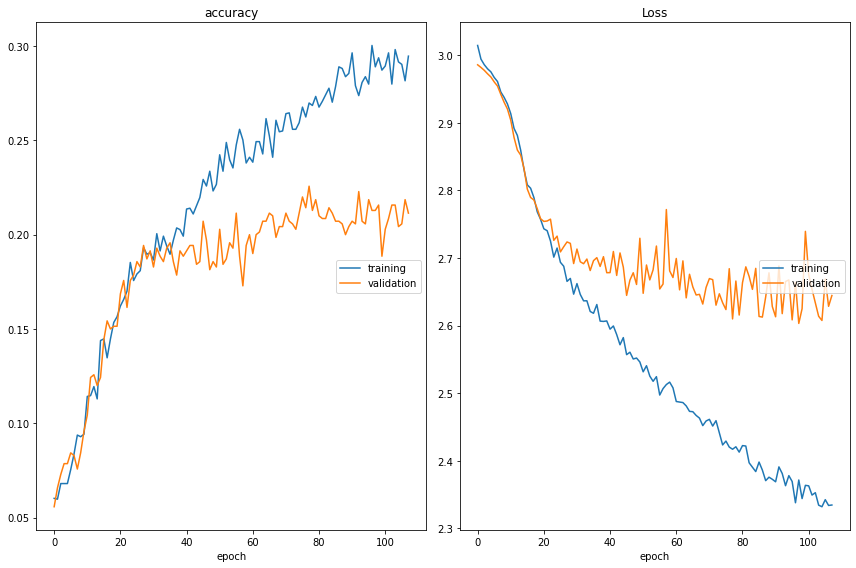

accuracy
	training         	 (min:    0.060, max:    0.300, cur:    0.295)
	validation       	 (min:    0.056, max:    0.226, cur:    0.211)
Loss
	training         	 (min:    2.332, max:    3.014, cur:    2.335)
	validation       	 (min:    2.603, max:    2.986, cur:    2.644)
Epoch 00108: early stopping


In [ ]:
history_rotated=model.fit_generator(rotation_train, steps_per_epoch=2314//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n // 20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/' + 'rotated_data_20_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1), plot_20breeds
              ])

In [ ]:
model.evaluate(aug_test)

27/27 [==============================] - 155s 6s/step - loss: 2.7118 - accuracy: 0.2210


[2.711832046508789, 0.22097378969192505]

### Model mixed: mixed data augmeuntation

In [ ]:
mixed_datagen = ImageDataGenerator(rescale=1/255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,
    shear_range=0.2,zoom_range=0.2, horizontal_flip=True)

In [ ]:
mixed_train=mixed_datagen.flow_from_directory(training_path, classes=breeds, batch_size=20, target_size=(224,224))

Found 2314 images belonging to 20 classes.


In [ ]:
history_mixed=model.fit_generator(mixed_train, steps_per_epoch=2314//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n // 20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/' + 'mixed_data_20_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
              ])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
115/115 [==============================] - 28s 240ms/step - loss: 2.7565 - accuracy: 0.1835 - val_loss: 2.6481 - val_accuracy: 0.2200

Epoch 00001: val_accuracy improved from -inf to 0.22000, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/mixed_data_20_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/mixed_data_20_breeds/assets
Epoch 2/1000
115/115 [==============================] - 27s 239ms/step - loss: 2.7674 - accuracy: 0.1757 - val_loss: 2.6503 - val_accuracy: 0.2114

Epoch 00002: val_accuracy did not improve from 0.22000
Epoch 3/1000
115/115 [==============================] - 27s 238ms/step - loss: 2.7547 - accuracy: 0.1761 - val_loss: 2.6280 - val_accuracy: 0.2214

Epoch 00003: val_accuracy improved from 0.22000 to 0.22143, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/20_breeds/mixed_data_20_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/

In [ ]:
model.evaluate(aug_test)

27/27 [==============================] - 2s 59ms/step - loss: 2.5841 - accuracy: 0.2135


[2.5840580463409424, 0.21348313987255096]

Similarly to the 5 breeds model, the **rotation 90°** data augmentation technique gave us the best accuracy result with **22%** 

We are going to use both **best hyper-parameters** and the **rotation** technique for our final 120 breeds model

# **120 Breeds** 

In [ ]:
rotation_gen=ImageDataGenerator(rotation_range=90,fill_mode='nearest',rescale=1/255)
rotation_train=rotation_gen.flow_from_directory(training_path, target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20)

In [ ]:
validation_gen=ImageDataGenerator(rescale=1/255)
aug_validation=validation_gen.flow_from_directory(validation_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

In [ ]:
test_gen=ImageDataGenerator(rescale=1/255)
aug_test=validation_gen.flow_from_directory(test_path,target_size=(224, 224),classes=os.listdir(training_path),
                              class_mode='categorical', batch_size=20, shuffle=False)

We are using the model with best hyper-parameters we get from the tuning process.

In addition we did choose the best augmentation technique which is the **rotation 90°**

In [ ]:
final_history=model.fit_generator(rotation_train, steps_per_epoch=13297//20, epochs=1000, verbose=1,
                          validation_data=aug_validation, validation_steps=aug_validation.n // 20,
                          callbacks=[History(),
               ModelCheckpoint('/content/drive/MyDrive/Formation_Machine_Learning/P6/120_breeds/' + 'data_120_breeds', monitor='val_accuracy', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, verbose=1)
              ])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
664/664 [==============================] - 4119s 6s/step - loss: 4.7836 - accuracy: 0.0105 - val_loss: 4.7620 - val_accuracy: 0.0106

Epoch 00001: val_accuracy improved from -inf to 0.01064, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/120_breeds/data_120_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/120_breeds/data_120_breeds/assets
Epoch 2/1000
664/664 [==============================] - 146s 220ms/step - loss: 4.7617 - accuracy: 0.0175 - val_loss: 4.7456 - val_accuracy: 0.0151

Epoch 00002: val_accuracy improved from 0.01064 to 0.01510, saving model to /content/drive/MyDrive/Formation_Machine_Learning/P6/120_breeds/data_120_breeds
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Formation_Machine_Learning/P6/120_breeds/data_120_breeds/assets
Epoch 3/1000
664/664 [==============================] - 145s 218ms/step - loss: 4.7445 - accuracy: 0.0183 - val_loss: 4.7101 - val_accuracy: 0.0265

Ep

In [ ]:
model.evaluate(aug_test)

152/152 [==============================] - 727s 5s/step - loss: 3.9595 - accuracy: 0.1238


[3.9595038890838623, 0.12380638718605042]

No handles with labels found to put in legend.


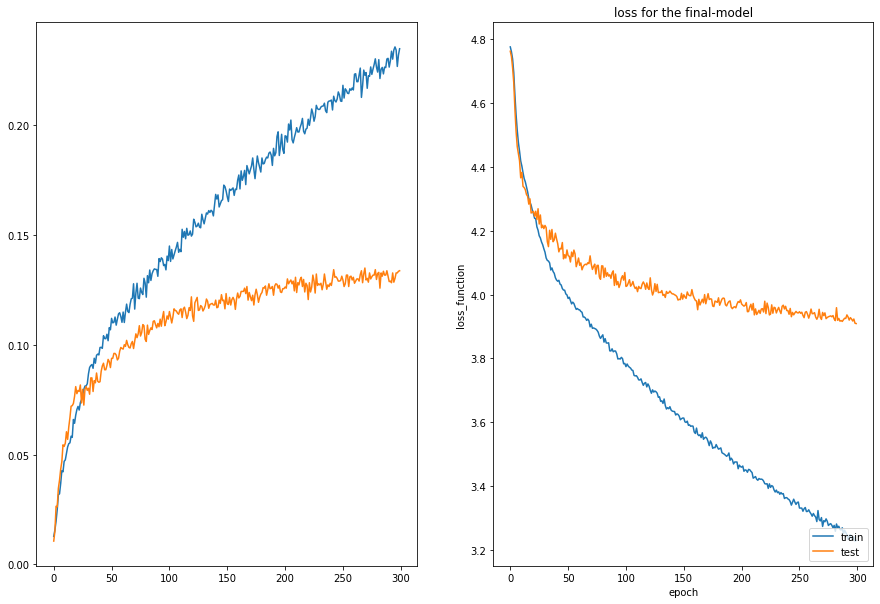

In [ ]:
f = plt.figure(figsize=(15, 10))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(final_history.history['accuracy'],label='train')
ax1.plot(final_history.history['val_accuracy'],label='test')
plt.title('accuracy for the final-model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')

ax2.plot(final_history.history['loss'],label='train')
ax2.plot(final_history.history['val_loss'],label='test')
plt.title('loss for the final-model')
plt.ylabel('loss_function')
plt.xlabel('epoch')
plt.legend(loc='lower right')

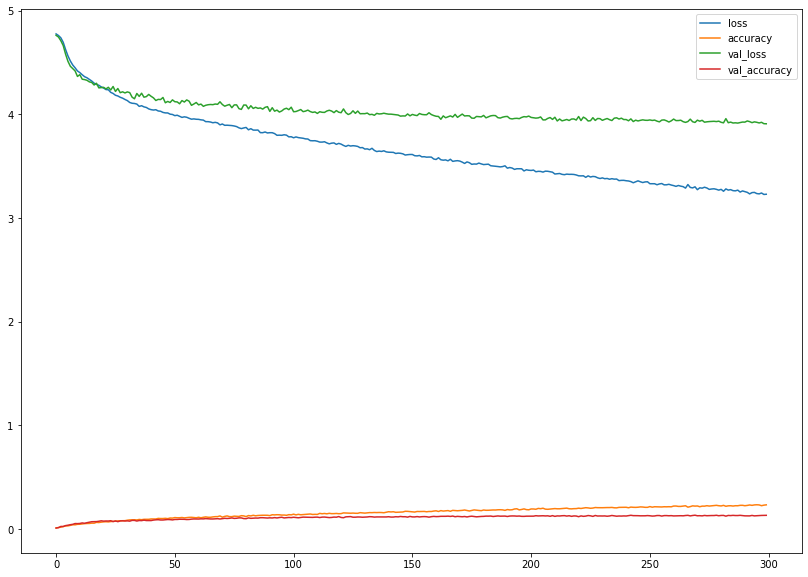

In [ ]:
pd.DataFrame(final_history.history).plot(figsize=(14,10))
plt.show()

Unfortunatly, we did get a low accuracy performance with 120 breeds. 

But this result seems to be fair with our Scrach CNN model

In [ ]:
final_model=tf.keras.models.load_model('/content/drive/MyDrive/Formation_Machine_Learning/P6/120_breeds/data_120_breeds/')

##test some dog images

In [ ]:
image_cardignan=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/Cardigan/n02113186_7608.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_doberman=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/Doberman/n02107142_6816.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_pekinese=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/Pekinese/n02086079_7944.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_basset=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/basset/n02088238_9717.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_briard=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/briard/n02105251_8540.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_boxer=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/boxer/n02108089_6295.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_kelpie=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/kelpie/n02105412_729.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_papillon=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/papillon/n02086910_8209.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_redbone=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/redbone/n02090379_5182.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
image_chow=cv2.imread('/content/drive/MyDrive/Formation_Machine_Learning/P6/data/resized_images/test_data/chow/n02112137_8212.jpg',cv2.IMREAD_UNCHANGED)

In [ ]:
def get_prediction(img):

  #img=cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
  
  labels=dict((v,k) for k,v in aug_test.class_indices.items())

  #adapt_image
  image = img.astype('float64')
  image /= 255
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))


  pred_proba=final_model.predict(image)
  pred1=np.argsort(pred_proba, axis=1)[:,-2:][0][0]
  pred2=np.argsort(pred_proba, axis=1)[:,-2:][0][1]
  
  res=print(f'the prediction might be {labels[pred1]} or {labels[pred2]} in probability order')

  return res

In [ ]:
get_prediction(image_briard)

the prediction might be groenendael or standard_poodle in probability order


In [ ]:
get_prediction(image_chow)

the prediction might be borzoi or Great_Pyrenees in probability order


In [ ]:
get_prediction(image_doberman)

the prediction might be flat coated_retriever or papillon in probability order


In [ ]:
get_prediction(image_kelpie)

the prediction might be Doberman or Bernese_mountain_dog in probability order


In [ ]:
get_prediction(image_papillon)

the prediction might be Siberian_husky or Border_collie in probability order


As we can see, predictions are not quite good. This was expected, since we have almost 12% accuracy of our CNN scrach model.

Lets move to the Transfer Learning methods to see if we get any improvment using such algorithms